In [ ]:
######################################################################
## 05_ANALYSIS: Methylation across gene regions
######################################################################

### Note that any block starting with "SCRIPT" or "ON COMMAND LINE" should be run in terminal and not in notebook

In [1]:
######################################################################
## BLOCK 1: Load libraries
######################################################################

suppressMessages({
  library(bsseq)
  library(GenomicFeatures)
  library(GenomicRanges)
  library(rtracklayer)
  library(GenomicAlignments)
  library(GenomeInfoDb)
  library(ggplot2)
  library(dplyr)
  library(tidyr)
  library(tidyverse)
  library(tximport)
})  

In [3]:
######################################################################
## BLOCK 2A: Load BSseq object
######################################################################

load("bsseq_snp_masked.RData")
bsseq <- BSseq_obj_masked

In [4]:
######################################################################
## BLOCK 2B: Load Expression data
######################################################################

# Load GFF
gff <- import("~/Mytilus/genome/ncbi_dataset/data/GCF_021869535.1/genomic.gff")

# Load Salmon output
txi <- tximport("~/Mytilus-expression/salmon_quant/quant.sf", type = "salmon", txOut = TRUE)

# Convert to data frame
expression_df <- as.data.frame(txi$abundance) %>%
  rownames_to_column("tx_id") %>%
  pivot_longer(-tx_id, names_to = "sample", values_to = "tpm")

## Extract protein → gene mapping from GFF

gff_df <- as.data.frame(gff)

# Filter for CDS features with both protein_id and gene ID
tx2gene <- gff_df %>%
  filter(type == "CDS" & !is.na(protein_id) & !is.na(gene)) %>%
  select(protein_id, gene_id = gene) %>%
  distinct()

## Merge expression with gene IDs

# Extract protein ID from tx_id in expression data
expression_df <- expression_df %>%
  mutate(protein_id = str_extract(tx_id, "XP_\\d+\\.\\d+"))

# Merge with tx2gene mapping
expression_df <- expression_df %>%
  left_join(tx2gene, by = "protein_id") %>%
  mutate(gene = paste0("gene-", gene_id)) %>%
  filter(!is.na(gene))  # Remove any unmatched IDs

## Summarize gene-level expression

expression_gene <- expression_df %>%
  group_by(gene) %>%
  slice_max(order_by = tpm, n = 1, with_ties = FALSE) %>%  # top protein per gene
  summarise(
    tpm = sum(tpm, na.rm = TRUE),
    protein_id = first(protein_id),
    .groups = "drop"
  )

head(expression_gene)

reading in files with read_tsv

1 




gene,tpm,protein_id
<chr>,<dbl>,<chr>
gene-LOC127698167,0.000000,XP_052080128.1
gene-LOC127698169,0.000000,XP_052057848.1
gene-LOC127698171,0.569278,XP_052057481.1
gene-LOC127698172,146.760455,XP_052057483.1
gene-LOC127698173,3.452572,XP_052057485.1
gene-LOC127698174,0.000000,XP_052057486.1


In [5]:
######################################################################
## BLOCK 3A: Extracting Gene Models
######################################################################

# Filter for gene features
genes <- gff[gff$type == "gene"]

# Filter to protein-coding genes
genes <- genes[
  !is.na(genes$gene_biotype) &
    genes$gene_biotype %in% c("protein_coding")
]

#  Assign gene_id (required by downstream functions)
genes$gene_id <- genes$Name  # Use Name column (e.g., LOC127xxxxx)

# Sanity check
length(genes)

[1] 26243

In [6]:
######################################################################
## BLOCK 3B: Make gene_id align with expression_gene$gene
######################################################################

# 1) Build the same "gene-<ID>" strings that expression_gene uses:
genes$gene_id <- paste0("gene-", genes$gene)

# 2) Pull in TPM by matching on that
genes$tpm <- expression_gene$tpm[
  match(genes$gene_id, expression_gene$gene)
]

# 3) Cut into Low/Intermediate/High
genes$expr_cat <- cut(
  genes$tpm,
  breaks = c(-Inf, 1, 10, Inf),
  labels = c("Low", "Intermediate", "High")
)

# 4) Sanity check
table(genes$expr_cat)


         Low Intermediate         High 
       15104         7298         3750 

In [7]:
######################################################################
## BLOCK 4: Methylation Binning
######################################################################

get_methylation_profile_by_gene <- function(bsseq_obj, gene_ranges, flank_size = 2000, nbins_body = 100, nbins_flank = 20, sample_name = NULL) {
  
  # Helper function: tile a region into n bins
  tile_region <- function(gr, nbins) {
    gr_tiled <- unlist(tile(gr, n = nbins))
    mcols(gr_tiled)$bin_index <- rep(1:nbins, times = length(gr))
    gr_tiled$gene_id <- rep(gr$gene_id, each = nbins)
    gr_tiled$region <- rep(gr$region, each = nbins)
    gr_tiled$gene_strand <- rep(as.character(strand(gr)), each = nbins)
    return(gr_tiled)
  }

  # Ensure gene_id is defined
  if (is.null(gene_ranges$gene_id)) {
    gene_ranges$gene_id <- names(gene_ranges)
  }

  # Define flanking regions and label region types
  upstream <- promoters(gene_ranges, upstream = flank_size, downstream = 0)
  upstream$region <- "upstream"

  downstream <- flank(gene_ranges, width = flank_size, start = FALSE)
  downstream$region <- "downstream"

  gene_body <- gene_ranges
  gene_body$region <- "body"

  # Tile regions
  upstream_tiled <- tile_region(upstream, nbins_flank)
  body_tiled <- tile_region(gene_body, nbins_body)
  downstream_tiled <- tile_region(downstream, nbins_flank)

  all_bins <- c(upstream_tiled, body_tiled, downstream_tiled)

  # Extract methylation values
  meth_matrix <- getMeth(bsseq_obj, regions = all_bins, type = "raw", what = "perRegion")
  
  if (is.null(sample_name)) {
    sample_name <- colnames(meth_matrix)[1]
  }

  # Assemble tidy dataframe
  df <- data.frame(
    gene_id = all_bins$gene_id,
    bin_index = all_bins$bin_index,
    region = all_bins$region,
    gene = all_bins$gene_strand,
    methylation = as.numeric(meth_matrix[, 1]),
    sample = sample_name
  )

  # Flip bins for genes on minus strand
  df <- df %>%
    group_by(gene_id, region) %>%
    mutate(bin_index = if_else(gene == "-", max(bin_index) + 1 - bin_index, bin_index)) %>%
    ungroup()

  # Global bin index for plotting
  df <- df %>%
    mutate(
      bin_global = case_when(
        region == "upstream" ~ bin_index,
        region == "body" ~ bin_index + nbins_flank,
        region == "downstream" ~ bin_index + nbins_flank + nbins_body
      )
    )

  return(df)
}

df_profile <- get_methylation_profile_by_gene(bsseq, genes)

# immediately join back on expr_cat
df_profile <- df_profile %>%
  left_join(
    as.data.frame(mcols(genes))[, c("gene_id","expr_cat")],
    by = "gene_id"
  )

# Check
head(df_profile)
summary(df_profile$methylation)
table(df_profile$region)

# save
saveRDS(df_profile, "df_profile.rds")

gene_id,bin_index,region,gene,methylation,sample,bin_global,expr_cat
<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<fct>
gene-LOC127711003,1,upstream,+,NA,M44-9-1yr,1,Low
gene-LOC127711003,2,upstream,+,NaN,M44-9-1yr,2,Low
gene-LOC127711003,3,upstream,+,0.00000000,M44-9-1yr,3,Low
gene-LOC127711003,4,upstream,+,0.05277778,M44-9-1yr,4,Low
gene-LOC127711003,5,upstream,+,0.06097561,M44-9-1yr,5,Low
gene-LOC127711003,6,upstream,+,0.07142857,M44-9-1yr,6,Low


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
    0.0     0.0     0.0     0.2     0.5     1.0 1314854 


      body downstream   upstream 
   2624300     524860     524860 

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


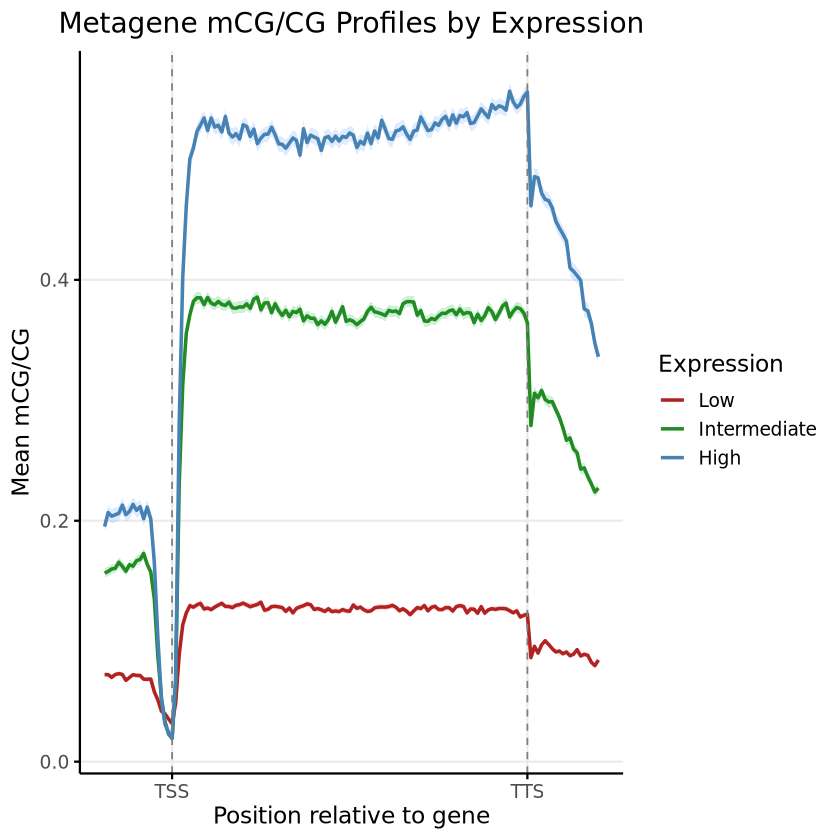

In [8]:
######################################################################
## BLOCK 5: Stratified metagene profile plot by expression category
######################################################################

library(dplyr)
library(ggplot2)

nbins_flank <- 20
nbins_body  <- 100

df_profile %>%
  filter(!is.na(expr_cat), !is.nan(methylation)) %>%
  group_by(expr_cat, bin_global) %>%
  summarise(
    mean_meth = mean(methylation, na.rm=TRUE),
    sem_meth  = sd(methylation, na.rm=TRUE)/sqrt(n()),
    .groups   = "drop"
  ) %>%
  ggplot(aes(x = bin_global, y = mean_meth, color = expr_cat)) +
    geom_ribbon(aes(ymin = mean_meth - sem_meth, ymax = mean_meth + sem_meth, fill = expr_cat),
                alpha = 0.2, color = NA, show.legend = FALSE) +  # no fill legend
    geom_line(size = 1) +
    geom_vline(xintercept = c(nbins_flank, nbins_flank + nbins_body),
               linetype   = "dashed", color = "gray50") +
    scale_x_continuous(
      breaks = c(nbins_flank, nbins_flank + nbins_body),
      labels = c("TSS", "TTS")
    ) +
    scale_color_manual(
      name   = "Expression",
      values = c("Low"="firebrick", "Intermediate"="forestgreen", "High"="steelblue")
    ) +
    labs(
      title = "Metagene mCG/CG Profiles by Expression",
      x     = "Position relative to gene",
      y     = "Mean mCG/CG"
    ) +
    theme_minimal(base_size = 14) +
    theme(
      plot.title       = element_text(hjust = 0.5),
      panel.grid.minor = element_blank(),
      axis.line        = element_line(color="black"),
      axis.ticks       = element_line(color="black")
    )

Warning message:
“Removed 27 rows containing missing values or values outside the scale range (`geom_line()`).”


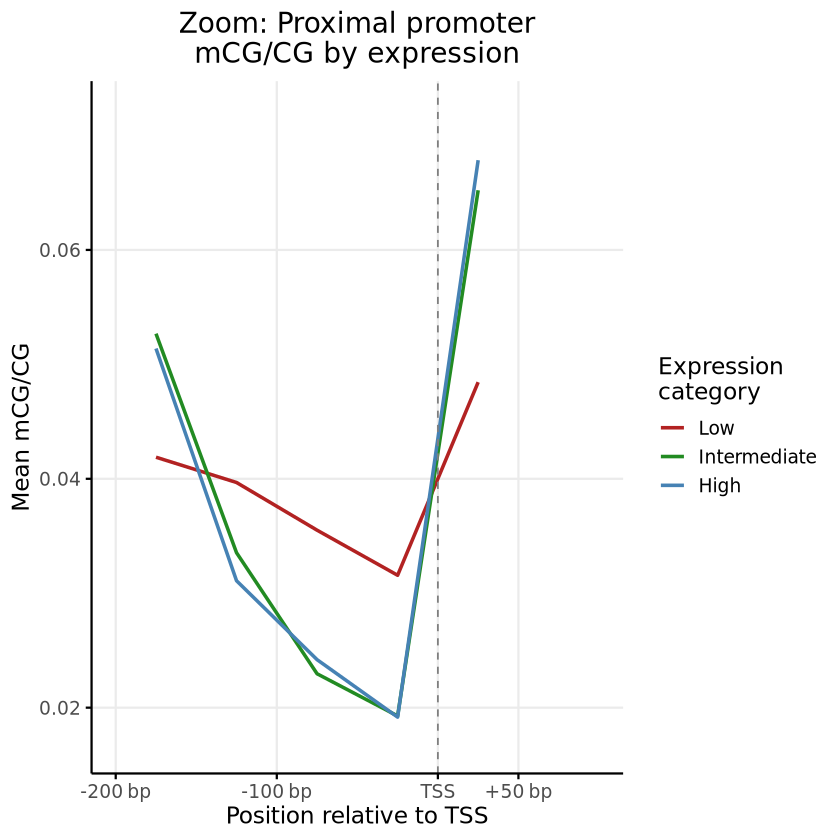

In [9]:
######################################################################
## BLOCK 6: Zoom on promoter
######################################################################

library(dplyr)
library(ggplot2)

# Parameters — must match BLOCK 4 tiling
flank_size   <- 1000
nbins_flank  <- 20
nbins_body   <- 20
bin_width    <- flank_size / nbins_flank      # e.g., 100 bp
body_scale   <- 1000                          # scaled gene body range in bp

# Filter and summarize promoter + gene body region
promoter_zoom_df <- df_profile %>%
  filter(
    !is.na(expr_cat),
    !is.na(methylation),
    (
      region == "upstream" &
      bin_index >= 10 #(nbins_flank - 200 / bin_width + 0.5)  # from -200 bp
    ) |
    (
      region == "body" &
      bin_index <= 3  # include first ~100 bp of gene body
    )
  ) %>%
  group_by(expr_cat, region, bin_index) %>%
  summarise(mean_meth = mean(methylation), .groups = "drop") %>%
  mutate(
    pos = case_when(
      region == "upstream" ~ -flank_size + (bin_index - 0.5) * bin_width,
      region == "body"     ~ (bin_index - 0.5) / nbins_body * body_scale
    )
  )

# Plot
ggplot(promoter_zoom_df, aes(x = pos, y = mean_meth, color = expr_cat)) +
  geom_line(size = 1) +
  geom_vline(xintercept = 0, linetype = "dashed", color = "gray50") +
  scale_x_continuous(
    limits = c(-200, 100),
    breaks = c(-200, -100, 0, 50),
    labels = c("-200 bp", "-100 bp", "TSS", "+50 bp")
  ) +
  scale_y_continuous(limits = c(0.017, 0.072)) +  # NEW Y-AXIS RANGE
  scale_color_manual(
    values = c("Low" = "firebrick", "Intermediate" = "forestgreen", "High" = "steelblue")
  ) +
  labs(
    title = "Zoom: Proximal promoter\nmCG/CG by expression",
    x     = "Position relative to TSS",
    y     = "Mean mCG/CG",
    color = "Expression\ncategory"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title       = element_text(hjust = 0.5),
    panel.grid.minor = element_blank(),
    axis.line        = element_line(color = "black"),
    axis.ticks       = element_line(color = "black")
  )

Warning message:
“Removed 27 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 27 rows containing missing values or values outside the scale range (`geom_line()`).”


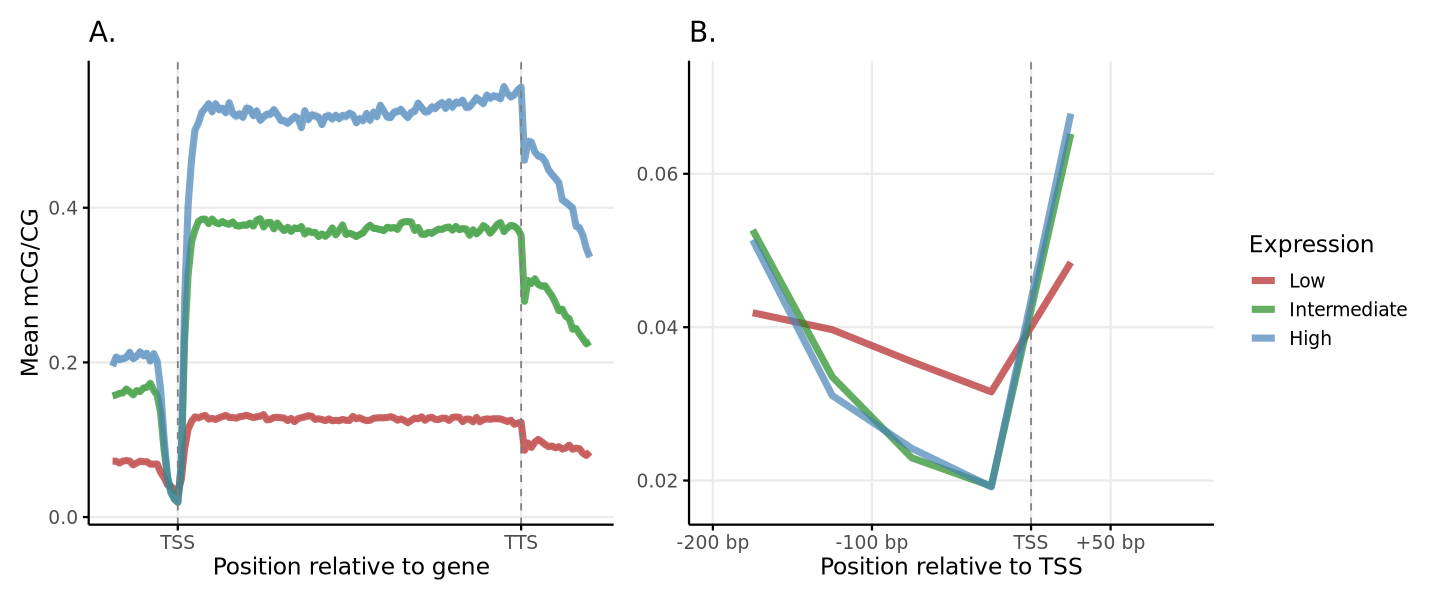

In [15]:
######################################################################
## BLOCK 7: Combined Metagene Profile and Promoter Zoom Plot
######################################################################

library(ggplot2)
library(dplyr)
library(patchwork)

# Panel A: Full-length metagene plot (no legend)
nbins_flank <- 20
nbins_body  <- 100

plot_meta <- df_profile %>%
  filter(!is.na(expr_cat), !is.nan(methylation)) %>%
  group_by(expr_cat, bin_global) %>%
  summarise(
    mean_meth = mean(methylation, na.rm = TRUE),
    sem_meth  = sd(methylation, na.rm = TRUE) / sqrt(n()),
    .groups   = "drop"
  ) %>%
  ggplot(aes(x = bin_global, y = mean_meth, color = expr_cat)) +
  geom_ribbon(aes(ymin = mean_meth - sem_meth, ymax = mean_meth + sem_meth, fill = expr_cat),
              alpha = 0.2, color = FALSE, show.legend = FALSE) +
  geom_line(size = 2, alpha = 0.7) +
  geom_vline(xintercept = c(nbins_flank, nbins_flank + nbins_body),
             linetype = "dashed", color = "gray50") +
  scale_x_continuous(
    breaks = c(nbins_flank, nbins_flank + nbins_body),
    labels = c("TSS", "TTS")
  ) +
  scale_color_manual(
    values = c("Low" = "firebrick", "Intermediate" = "forestgreen", "High" = "steelblue"),
    guide = "none"
  ) +
  labs(
    title = "A.",
    x = "Position relative to gene",
    y = "Mean mCG/CG"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(hjust = 0),
    panel.grid.minor = element_blank(),
    axis.line = element_line(color = "black"),
    axis.ticks = element_line(color = "black")
  )

# Panel B: Zoom in on promoter (legend appears here)
flank_size   <- 1000
nbins_flank  <- 20
nbins_body   <- 20
bin_width    <- flank_size / nbins_flank
body_scale   <- 1000

promoter_zoom_df <- df_profile %>%
  filter(
    !is.na(expr_cat),
    !is.na(methylation),
    (
      region == "upstream" & bin_index >= 10
    ) |
    (
      region == "body" & bin_index <= 3
    )
  ) %>%
  group_by(expr_cat, region, bin_index) %>%
  summarise(mean_meth = mean(methylation), .groups = "drop") %>%
  mutate(
    pos = case_when(
      region == "upstream" ~ -flank_size + (bin_index - 0.5) * bin_width,
      region == "body"     ~ (bin_index - 0.5) / nbins_body * body_scale
    )
  )

options(repr.plot.width = 12, repr.plot.height = 5)

plot_promoter <- ggplot(promoter_zoom_df, aes(x = pos, y = mean_meth, color = expr_cat)) +
  geom_line(size = 2, alpha = 0.7) +
  geom_vline(xintercept = 0, linetype = "dashed", color = "gray50") +
scale_x_continuous(
  limits = c(-200, 100),
  breaks = c(-200, -100, 0, 50),
  labels = c(expression("-200 bp"), expression("-100 bp"), "TSS", expression("+50 bp"))
  ) +
  scale_y_continuous(limits = c(0.017, 0.072)) +
  scale_color_manual(
    name = "Expression",
    values = c("Low" = "firebrick", "Intermediate" = "forestgreen", "High" = "steelblue")
  ) +
  labs(
    title = "B.",
    x = "Position relative to TSS",
    y = NULL,  # <- REMOVE Y-axis label
    color = "Expression"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(hjust = 0),
    panel.grid.minor = element_blank(),
    axis.line = element_line(color = "black"),
    axis.ticks = element_line(color = "black"),
    legend.position = "right"
  )

# Combine panels
combined <- plot_meta + plot_promoter +
  plot_layout(widths = c(1, 1))

combined

ggsave(
  "Fig2.pdf",
  combined,
  width = 13, height = 5,
)